In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
# import mpl_axes_aligner

# import seaborn as sns
# import zipfile
# from cycler import cycler

pd.options.display.float_format = '{:.4f}'.format


# global plotting settings
plt.style.use(['ggplot'])

# default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
#                   cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
                     # 'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (10*1.8, 5.65*1.8),
                     'mathtext.default' : 'regular'
                    })

# plt.rc('axes', prop_cycle=default_cycler)

In [2]:
# format to FLUXNET
def save_fluxnet(filepath, save_as=None):
    
    if save_as is None:
        save_as = filepath[:-4] + '_fluxnet.csv'
    
    df = (pd.read_csv(filepath, header=0, low_memory=False)
          .replace(-9999, np.nan).replace(99999, np.nan) # set missing to np.nan for unit conversions
          .rename(columns = {'co2_mole_fraction': 'CO2', # umol mol-1
                             'co2_mixing_ratio': 'CO2_MIXING_RATIO', # umol mol-1
                             'ch4_mole_fraction': 'CH4', # umol mol-1 (convert to nmol below)
                             'ch4_mixing_ratio': 'CH4_MIXING_RATIO', # umol mol-1 (convert to nmol below)
                             'co2_flux': 'FC', # umol m-2 s-1
                             'ch4_flux': 'FCH4', # umol m-2 s-1 (convert to nmol below)
                             'h2o_mole_fraction': 'H2O', # mmol mol-1
                             'h2o_mixing_ratio': 'H2O_MIXING_RATIO', # mmol mol-1
                             'h2o_flux': 'FH2O', # mmol m-2 s-1
                             'co2_strg': 'SC', # umol s-1 m-2
                             'ch4_strg': 'SCH4', # umol s-1 m-2 (convert to nmol below)
                             'H_strg': 'SH', # W m-2
                             'LE_strg': 'SLE', # W m-2
                             'air_pressure': 'PA', # Pa (convert to kPa below)
                             'sonic_temperature': 'T_SONIC', # K
                             'air_temperature': 'TA', # K
                             'Precip': 'P', # mm
                             'RN': 'NETRAD', # W m-2 (is met tower giving W m-2?)
                             'L': 'MO_LENGTH', # m
                             'qc_Tau': 'TAU_SSITC_TEST', 
                             'un_Tau': 'TAU_UNCORR',
                             'Tau': 'TAU', # kg m-2 s-1
                             'u.': 'USTAR',
                             'wind_dir': 'WD',
                             'wind_speed': 'WS',
                             'max_wind_speed': 'WS_MAX',
                             'X.z.d..L': 'ZL',
                             'Reco': 'RECO',
#                              'Tsoil': 'TS', 
                             'x_peak': 'FETCH_MAX', # m
                             'x_90.': 'FETCH_90', # m
                             'x_70.': 'FETCH_70', # m
#                              'x_55.': 'FETCH_55', # m
#                              'x_40.': 'FETCH_40', # m
                             'qc_co2_flux': 'FC_SSITC_TEST',
                             'un_co2_flux': 'FC_UNCORR',
                             'qc_ch4_flux': 'FCH4_SSITC_TEST',
                             'un_ch4_flux': 'FCH4_UNCORR',
                             'qc_H': 'H_SSITC_TEST',
                             'un_H': 'H_UNCORR',
                             'qc_LE': 'LE_SSITC_TEST',
                             'un_LE': 'LE_UNCORR',
                             'qc_Tau': 'TAU_SSITC_TEST'
                            }, errors = 'raise')
          .assign(TIMESTAMP = lambda x: pd.to_datetime(x['DATE']).dt.strftime('%Y%m%d%H%M'),
                  TIMESTAMP_END = lambda x: x['TIMESTAMP'],
#                   H2O = lambda x: x['H2O'] / 1000, # umol mol-1 to mmol mol-1
                  CH4 = lambda x: x['CH4'] * 1000, # umol mol-1 to nmol mol-1
                  CH4_MIXING_RATIO = lambda x: x['CH4_MIXING_RATIO'] * 1000, # umol mol-1 to nmol mol-1
                  FCH4 = lambda x: x['FCH4'] * 1000, # umol m-2 s-1 to nmol m-2 s-1
                  SCH4 = lambda x: x['SCH4'] * 1000, # umol s-1 m-2 to nmol s-1 m-2
                  PA = lambda x: x['PA'] * 0.001, # Pa to kPa
                  VPD = lambda x: x['VPD'] * 0.01 # Pa to hPa
                 )
          .replace(np.nan, -9999) # set np.nan to -9999 for FLUXNET formatting
         )
    df.index = df.index.set_names(None)

    df.columns = df.columns.str.replace('Reco_', 'RECO_')
    df.columns = df.columns.str.replace('Tsoil', 'TS')

    cols_to_move = ['TIMESTAMP']
    df = df[ cols_to_move + [ col for col in df.columns if col not in cols_to_move ] ]
    
    df.to_csv(save_as, index = False)
#     df.to_csv(save_as=f'./output/csv/ATMOS_L3_{datetime.now().strftime("%Y-%m-%d")}_fluxnet.csv', index=False)
    
    return df

## Outputting thesis fluxes to FLUXNET

In [3]:
data_dir = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/'

def read_l3(filepath, datecol='DATE'):
    df = (pd.read_csv(filepath, header=0, low_memory=False)
      .replace(-9999, np.nan).replace(99999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x[datecol]))
      .set_index('date', drop=False)
     )
    df.index = df.index.set_names(None)
    return df

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25.csv' # Linux

# l3 = read_l3(filepath)

# predictors = 'baseflux'
# filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
# rf = read_l3(filepath).add_suffix('_RF')

# filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/ann_predictors_laplace.csv'
# ann = read_l3(filepath).add_suffix('_ANN')

# l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':], ann.loc[:,'FCH4_F_ANN':]], axis=1)
# # l3.to_csv('./output/csv/ATMOS_L3_{datetime.now().strftime("%Y%m%d")}_ch4gapfilled.csv', index = False)

# platt_constant = rf['FCH4_F_UNCERTAINTY_RF'] / rf.loc[:, [f'FCH4_F{i}_RF' for i in range(1,11)]].std(axis=1)
# # (platt_constant)

# output L3 fluxes with ch4 gap filling

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25_fluxgapfill.csv' # Linux
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L3_2024-06-11.csv" # Windows
l3 = read_l3(filepath)

# predictors = 'all'
filepath = r"C:\Users\ottob\data\atmos-flux-data\methane-gapfill\data\ATMOS_20240516_all\gapfilled\rf_predictors_laplace.csv"
rf = read_l3(filepath).add_suffix('_RF')

# filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/ann_predictors_laplace.csv'
# ann = read_l3(filepath).add_suffix('_ANN')

l3 = pd.concat([
    l3, 
    rf.loc[:,'FCH4_F_RF':], 
    # ann.loc[:,'FCH4_F_ANN':],
    ], axis=1)
l3.to_csv(f'./output/csv/ATMOS_L3_{datetime.now().strftime("%Y-%m-%d")}_ch4gapfilled.csv', index = False)

filepath = os.path.join(os.getcwd(), 'output', 'csv', f'ATMOS_L3_{datetime.now().strftime("%Y-%m-%d")}_ch4gapfilled.csv')
fluxnet = save_fluxnet(filepath)
# df = pd.read_csv('./output/csv/ATMOS_L3_{datetime.now().strftime("%Y%m%d")}_fluxnet.csv')

In [4]:
fluxnet

,TIMESTAMP,DATE,filename,date,time,DOY,daytime,file_records,used_records,TAU,...,FCH4_F2_RF,FCH4_F3_RF,FCH4_F4_RF,FCH4_F5_RF,FCH4_F6_RF,FCH4_F7_RF,FCH4_F8_RF,FCH4_F9_RF,FCH4_F10_RF,TIMESTAMP_END
0,202205241030,2022-05-24 10:30:00,2022-05-24T100000_AIU-2189.ghg,2022-05-24 10:30:00,10:30,144.4374,1.0000,18000.0000,18000.0000,-9999.0000,...,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,202205241030
1,202205241100,2022-05-24 11:00:00,2022-05-24T103000_AIU-2189.ghg,2022-05-24 11:00:00,11:00,144.4582,1.0000,18000.0000,18000.0000,-0.1241,...,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,202205241100
2,202205241130,2022-05-24 11:30:00,not_enough_data,2022-05-24 11:30:00,11:30,144.4790,-9999.0000,-9999.0000,-9999.0000,-9999.0000,...,-50.9483,-10.1275,30.1887,-48.0814,10.4440,69.6858,-55.6411,-39.6889,-42.8759,202205241130
3,202205241200,2022-05-24 12:00:00,not_enough_data,2022-05-24 12:00:00,12:00,144.4990,-9999.0000,-9999.0000,-9999.0000,-9999.0000,...,-25.8404,7.9675,11.4571,-14.2098,-8.2080,-48.0824,16.9516,-7.1702,-20.6178,202205241200
4,202205241230,2022-05-24 12:30:00,2022-05-24T120000_AIU-2189.ghg,2022-05-24 12:30:00,12:30,144.5207,1.0000,18000.0000,18000.0000,-0.1915,...,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,202205241230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27605,202312201300,2023-12-20 13:00:00,2023-12-20T123000_AIU-2189.ghg,2023-12-20 13:00:00,13:00,354.5415,1.0000,18000.0000,18000.0000,-0.0261,...,-42.2010,9.4160,19.2701,-9.9898,-2.1495,16.2945,1.4619,16.0918,-16.1367,202312201300
27606,202312201330,2023-12-20 13:30:00,2023-12-20T130000_AIU-2189.ghg,2023-12-20 13:30:00,13:30,354.5624,1.0000,18000.0000,18000.0000,-0.0883,...,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,202312201330
27607,202312201400,2023-12-20 14:00:00,2023-12-20T133000_AIU-2189.ghg,2023-12-20 14:00:00,14:00,354.5832,1.0000,18000.0000,18000.0000,-0.0292,...,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,202312201400
27608,202312201430,2023-12-20 14:30:00,2023-12-20T140000_AIU-2189.ghg,2023-12-20 14:30:00,14:30,354.6040,1.0000,18000.0000,18000.0000,-0.0437,...,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,202312201430


In [10]:
fluxnet[fluxnet.columns[fluxnet.columns.str.contains('FCH4_')]]

,FCH4_SSITC_TEST,FCH4_UNCORR,FCH4_f,FCH4_fsd,FCH4_F_RF,FCH4_F_UNCERTAINTY_RF,FCH4_F1_RF,FCH4_F2_RF,FCH4_F3_RF,FCH4_F4_RF,FCH4_F5_RF,FCH4_F6_RF,FCH4_F7_RF,FCH4_F8_RF,FCH4_F9_RF,FCH4_F10_RF
0,0.0000,-0.0362,-0.0099,0.0241,-9.8598,0.0000,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598,-9.8598
1,0.0000,-0.0492,-0.0353,0.0180,-35.2920,0.0000,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920,-35.2920
2,-9999.0000,-9999.0000,-0.0321,0.0705,-18.1271,60.0385,-44.2267,-50.9483,-10.1275,30.1887,-48.0814,10.4440,69.6858,-55.6411,-39.6889,-42.8759
3,-9999.0000,-9999.0000,-0.0453,0.0576,-8.7070,27.8212,0.6826,-25.8404,7.9675,11.4571,-14.2098,-8.2080,-48.0824,16.9516,-7.1702,-20.6178
4,0.0000,-0.1480,-0.1073,0.0741,-107.2850,0.0000,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850,-107.2850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27605,0.0000,-0.0587,0.0030,0.0048,1.4442,28.4696,22.3853,-42.2010,9.4160,19.2701,-9.9898,-2.1495,16.2945,1.4619,16.0918,-16.1367
27606,1.0000,-0.0218,0.0036,0.0043,3.5551,0.0000,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551,3.5551
27607,0.0000,-0.0135,-0.0037,0.0051,-3.7165,0.0000,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165,-3.7165
27608,0.0000,-0.0083,0.0084,0.0043,8.4019,0.0000,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019,8.4019


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

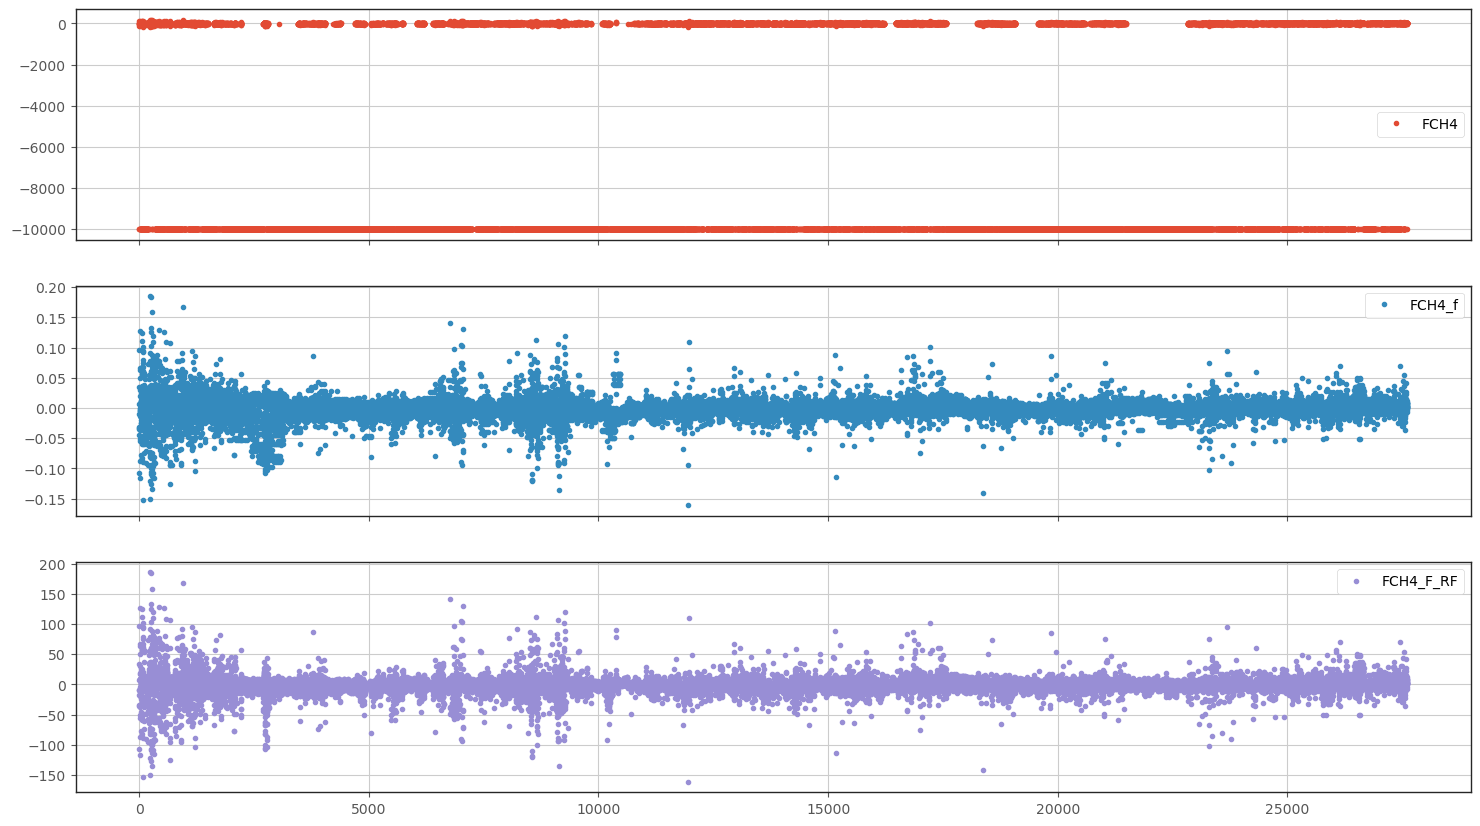

In [17]:
# fluxnet[['FCH4', 'FCH4_f', 'FCH4_F_RF']].plot(subplots=True)

## Annual metrics

In [2]:
cols = ['TA_EP','T60','Tsoil_mean','SWC_mean','Precip']

annualmet = l3[cols].agg(['mean', 'min', 'max'])
annualmet.loc['sum', 'Precip'] = l3.loc[:, 'Precip'].sum()
annualmet.loc['std', ['TA_EP', 'T60', 'Tsoil_mean', 'SWC_mean']] = l3.loc[:, ['TA_EP', 'T60', 'Tsoil_mean', 'SWC_mean']].std()
# mean and standard deviation of TA_EP, mean and ReddyProc unc of co2_flux, mean and gap-fill unc of FCH4

# annualmet.loc['uncertainty', :] = annualmet.std()
# annualmet.loc['uncertainty', ['NEE_f','co2_flux','FCH4_f','FCH4_F_RF']] = np.NaN

annualmet

,TA_EP,T60,Tsoil_mean,SWC_mean,Precip
mean,12.5219,12.0268,11.5006,0.3027,0.1156
min,-23.1185,-18.4000,1.6865,0.1573,0.0000
max,36.6963,34.8000,22.7450,0.4286,67.3000
sum,NaN,NaN,NaN,NaN,810.8000
std,11.7231,10.8633,7.2354,0.0819,NaN


In [3]:
cols = [f'FCH4_F{i}_RF' for i in range(1,11)]
model_sum = l3.loc[:, cols].sum(axis=0) * 1800 / 1000 / 1000 * 12.01
ch4_budget = [model_sum.mean(), model_sum.std() * 1.4210]
ch4_budget
# model_sum

[-0.3816044614926144, 3.0614157890823375]

In [4]:
ustars = l3.loc[:, 'ustar_thr'].unique()
ustars

array([0.14981061, 0.194696  ])

In [5]:
cols = ['ch4_flux', 'co2_flux', 'h2o_flux', 'NEE_f', 'FCH4_F_RF']
data_coverage = l3[cols].count()/l3.shape[0]
data_coverage

ch4_flux    0.3674
co2_flux    0.5446
h2o_flux    0.5681
NEE_f       1.0000
FCH4_F_RF   1.0000
dtype: float64

In [6]:
umoltogC = 1800 / 1000 / 1000 * 12.01 # [umol m-2 s-1] * (s 30min-1) / (umol mmol-1) / (mmol mol-1) * (gC molC-1)
umoltomgC = 1800 / 1000 * 12.01 # [umol m-2 s-1] * (s 30min-1) / (umol mmol-1) * (mgC mmolC-1)
cols = ['ch4_flux','FCH4_f', 'FCH4_F_ANN', 'FCH4_F_RF', 'co2_flux', 'NEE_f', 'GPP_f', 'Reco']
budget = l3[cols] * umoltogC
budget = budget.sum(axis=0)
budget['H_f'] = l3['H_f'].sum() / 1000
budget['LE_f'] = l3['LE_f'].sum() / 1000
# budget['NEE_%grow'] = l3.loc['2022-06':'2022-09-01', 'NEE_f'].sum()
budget['FCH4_uptake'] = l3.loc[l3['FCH4_F_RF']<0, 'FCH4_F_RF'].sum() * umoltogC
budget['FCH4_emission'] = l3.loc[l3['FCH4_F_RF']>0, 'FCH4_F_RF'].sum() * umoltogC
budget['FCH4_uptake%'] = budget['FCH4_uptake'] / (abs(budget['FCH4_uptake']) + abs(budget['FCH4_emission']))
budget['FCH4_emission%'] = budget['FCH4_emission'] / (abs(budget['FCH4_uptake']) + abs(budget['FCH4_emission']))
budget['FCH4_co2eq'] = budget['FCH4_F_RF'] / 12.01 * 16.04 * 45
budget['FCH4_co2eq_up'] = budget['FCH4_uptake'] / 12.01 * 16.04 * 45
budget['FCH4_co2eq_emit'] = budget['FCH4_emission'] / 12.01 * 16.04 * 45
budget['NEE_co2eq'] = budget['NEE_f'] / 12.01 * 44.01 # gC to molC, molC to gCO2
budget['rad_balance'] = (budget['FCH4_co2eq_up']) + (budget['FCH4_co2eq_emit']) + budget['NEE_co2eq']
# pd.concat([budget, pd.DataFrame({'rad_balance': budget['FCH4_F_RF'] * 45 + budget['NEE_f'], 
#                                  'ch4_to_0rad': budget['NEE_f'] / 45})])
budget['ch4_to_0rad'] = -(budget['NEE_co2eq'] / 45 / 16.04 * 12.01) # gCO2eq to gCH4, gCH4 to molC, molC to gC  
budget

ch4_flux            -0.3512
FCH4_f              -0.5024
FCH4_F_ANN        -550.6893
FCH4_F_RF           -0.3816
co2_flux          -356.7822
NEE_f              -18.5232
GPP_f             1804.8325
Reco              1786.3092
H_f                199.8094
LE_f               859.9817
FCH4_uptake         -1.8768
FCH4_emission        1.4952
FCH4_uptake%        -0.5566
FCH4_emission%       0.4434
FCH4_co2eq         -22.9344
FCH4_co2eq_up     -112.7970
FCH4_co2eq_emit     89.8626
NEE_co2eq          -67.8774
rad_balance        -90.8118
ch4_to_0rad          1.1294
dtype: float64

In [8]:
weekly = l3.groupby(l3.date.dt.to_period('W')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                   ).reset_index().set_index('date')
# weekly.index = weekly.index.set_names(None)

monthly = l3.groupby(l3.date.dt.to_period('M')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                   ).reset_index().set_index('date')
# monthly.index = monthly.index.set_names(None)

# # cols = ['FC', 'NEE_f', 'Reco', 'GPP_f', 'FCH4', 'FCH4_f', 'H_f'] # Fluxnet variables
# cols = ['co2_flux', 'NEE_f', 'Reco', 'GPP_f', 'ch4_flux', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN', 'LE', 'LE_f','H_f'] # Full output variables

# dailysum = l3.loc[:, cols].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
# dailysum.loc[:, 'LE_f'] = l3.loc[:, ['LE_f']].groupby(pd.Grouper(freq='1D')).sum()

# daily = l3.loc[:, cols].groupby(l3.index.floor('D')).mean()
# # daily[['FCH4', 'FCH4_f', 'FCH4_F_ANN']]
# # daily.loc[:,'FCH4']
# daily

daily = l3.groupby(l3.date.dt.to_period('D')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                 ).reset_index().set_index('date')

hourly = l3.groupby(l3.date.dt.to_period('H')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                 ).reset_index().set_index('date')

In [9]:
daily.loc['2022-11':'2023-02','LE_f_sum'].max()

2.1358680826686793

In [10]:
output = monthly.drop(columns=['GPP_f_mean', 'Reco_mean'])
# output.to_csv('./output/thesis/monthly_metrics.csv', index = True)

## Cutting L3 fluxes to first year (May 2022 - May 2023) for gap-filling

In [16]:
filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2024-01-31.csv'
fluxnet = save_fluxnet(filepath)

In [24]:
df = pd.read_csv('./processed/ATMOS_L3_2024-01-31_fluxnet.csv', header = 0, low_memory=False)

df2 = df.loc[df['TIMESTAMP_END']<202305241100, :]
# df2.to_csv('./processed/ATMOS_L3_2024-01-31_fluxnet_year1.csv', index=False)